In [9]:
import os, random
from unicodedata import name
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model_1 import apaDNNModel, apaDataset
import pickle
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import seqlogo

In [18]:
model = apaDNNModel(
    opt="Adam",
    loss="mse",
    lambda1=50,
    device='cuda',
    # Conv block 1 hparamaters
    conv1kc=128,
    conv1ks=12,
    conv1st=1,
    pool1ks=25,
    pool1st=25,
    cnvpdrop1=0.2,
    # multihead attention block
    Matt_heads=8,
    Matt_drop = 0.2,
    # FC block 1 (Matt output flattened)
    fc1_L1=0,  # 8192
    fc1_L2=8192,
    fc1_L3=4048,
    fc1_L4=1024,
    fc1_L5=512,
    fc1_L6=256,
    fc1_dp1=0.3,
    fc1_dp2=0.25,
    fc1_dp3=0.25,
    fc1_dp4=0.2,
    fc1_dp5=0.1,
    # FC block 2 (celltype profile + overall representation)
    fc2_L1=0,
    fc2_L2=128,
    fc2_L3=32,
    fc2_L4=16,
    fc2_L5=1,
    fc2_dp1=0.2,
    fc2_dp2=0.2,
    fc2_dp3=0,
    fc2_dp4=0,
    lr=2.5e-05,
    adam_weight_decay=0.06,
)
model.compile()
model.load_state_dict(
    torch.load(
        "/home/aiden/data/APA/input_data/model_results/all_cells_CNN_Matt_V2_4_L2_resNET.pt"
    ,map_location=torch.device('cuda'))
)
model.to("cuda")

apaDNNModel(
  (conv_block_1): ConvBlock(
    (op): Sequential(
      (0): Conv1d(4, 128, kernel_size=(12,), stride=(1,), padding=(6,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool1d(kernel_size=25, stride=25, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
  )
  (Matt_1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
  )
  (fc1): FC_block(
    (op): Sequential(
      (0): Linear(in_features=20480, out_features=8192, bias=True)
      (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.3, inplace=False)
      (4): Linear(in_features=8192, out_features=4048, bias=True)
      (5): BatchNorm1d(4048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.25, inplace=False)
      (8): Lin

In [19]:
data_root = "/home/aiden/data/APA/input_data/data_for_DL/V2/"
test_data = np.load(data_root + "C9ALS_test_labels.npy", allow_pickle=True)
test_seq = np.load(data_root + "C9ALS_test_seqs.npy", allow_pickle=True)

profiles = pd.read_csv(data_root + "celltype_profiles.tsv", index_col=0, sep="\t")
test_data_loader = DataLoader(
apaDataset(test_seq, test_data, profiles, device='cpu'),
batch_size=32,
drop_last=False,
)

In [5]:
# ok lets run these for all the data by iterating over the test data loader
# first lets to the filter importance part
# stack all the filter importance so we end up with a 3d array (datasize, 200, 128)
 
# create empty array
filter_importance = np.zeros((len(test_data_loader)*32, 128, 160))
position_weights = np.zeros((len(test_data_loader)*32, 160, 160))

for i, batch in enumerate(test_data_loader):
    seq_X, celltype_X, celltype_name, y = batch
    batch_size = seq_X.shape[0]
    # output MATT layer from model
    fmap = model.conv_block_1(seq_X)
    fmap = fmap.permute(2, 0, 1)
    wfmap, weights = model.Matt_1(fmap, fmap, fmap)
    wfmap = wfmap.permute(1, 2, 0) 
    wfmap = wfmap.cpu().detach().numpy()
    weights = weights.cpu().detach().numpy()
    filter_importance[i:i+batch_size] = wfmap
    position_weights[i:i+batch_size] = weights
print(filter_importance.shape)
print(position_weights.shape)    

(52672, 128, 160)
(52672, 160, 160)


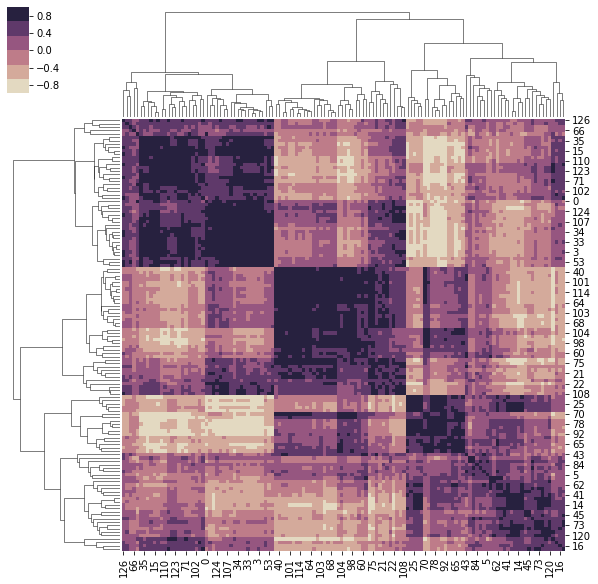

In [6]:
# run filter_importance = np.mean(np.abs(filter_importance), dim=0)  for the numpy array filter_importance
filter_importance_t = np.mean(np.abs(filter_importance), axis=0)  # shape: (128, 160)
# Calculate the correlation between filters at each position
cls = sns.color_palette("ch:s=-.2,r=.6")
correlation = np.corrcoef(filter_importance_t)  
sns.clustermap(correlation, cmap=cls, vmin=-1, vmax=1)

(160, 160)


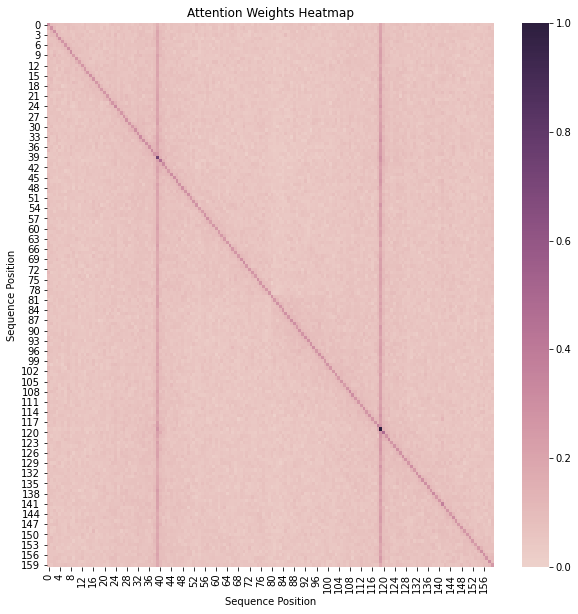

In [7]:
# run filter_importance = np.mean(np.abs(filter_importance), dim=0)  for the numpy array filter_importance
position_weights = np.mean(position_weights, axis=0)  # shape: (128, 200)
print(position_weights.shape)
# Calculate the correlation between filters at each position
min_weight, max_weight = np.min(position_weights), np.max(position_weights)
# normalize using min and max weights
norm_weights = (position_weights - min_weight) / (max_weight - min_weight)
# create a good looking heatmap using sns
cls = sns.cubehelix_palette(as_cmap=True)
plt.figure(figsize=(10, 10))
sns.heatmap(norm_weights, cmap=cls)
# x label and y labels 
plt.xlabel('Sequence Position')
plt.ylabel('Sequence Position')
plt.title('Attention Weights Heatmap')
# legned bar label
# plt.colorbar(label='Attention Weight')
plt.show()
# 

(128, 160)


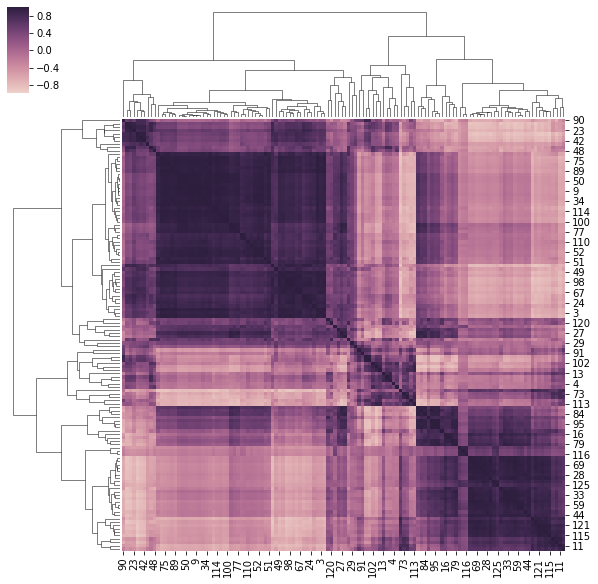

In [8]:
# run filter_importance = np.mean(np.abs(filter_importance), dim=0)  for the numpy array filter_importance
# zero the negative values
filter_importance_t = filter_importance
filter_importance_t[filter_importance_t < 0] = 0
filter_importance_t = np.mean(filter_importance_t, axis=0)  # shape: (128, 200)
print(filter_importance_t.shape)
# Calculate the correlation between filters at each position
correlation = np.corrcoef(filter_importance_t)  
sns.clustermap(correlation, cmap=cls, vmin=-1, vmax=1)

(128, 160)


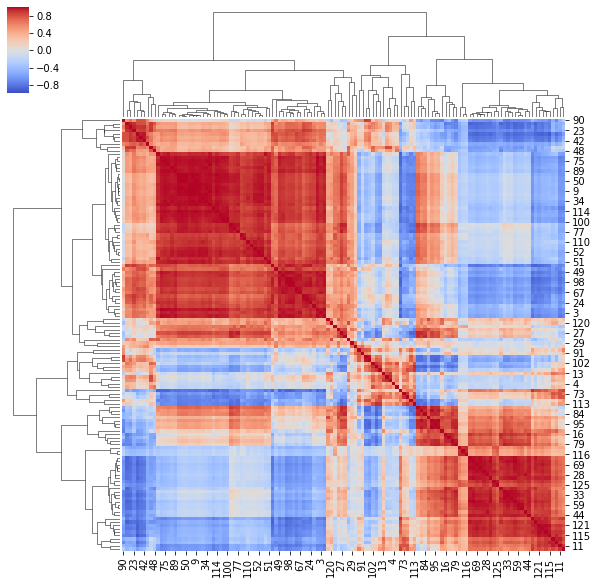

In [9]:
# run filter_importance = np.mean(np.abs(filter_importance), dim=0)  for the numpy array filter_importance
# zero the negative values
filter_importance_t = filter_importance
filter_importance_t[filter_importance_t < 0] = 0
filter_importance_t = np.mean(filter_importance_t, axis=0)  # shape: (128, 200)
print(filter_importance_t.shape)
# Calculate the correlation between filters at each position
correlation = np.corrcoef(filter_importance_t)  
sns.clustermap(correlation, cmap='coolwarm', vmin=-1, vmax=1)

In [15]:
filter_importance_t_df = pd.DataFrame(filter_importance_t)
new_index_names = ['filter_{}'.format(i) for i in range(128)]
filter_importance_t_df.index = new_index_names
filter_importance_t_df


,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
filter_0,0.000409,0.000389,0.000389,0.000389,0.000397,0.000384,0.000386,0.000381,0.000387,0.000388,...,0.000383,0.000381,0.000394,0.000379,0.000392,0.000381,0.000398,0.000390,0.000386,0.000382
filter_1,0.000009,0.000012,0.000010,0.000011,0.000011,0.000012,0.000010,0.000010,0.000013,0.000012,...,0.000010,0.000010,0.000009,0.000008,0.000009,0.000009,0.000014,0.000013,0.000010,0.000008
filter_2,0.000005,0.000005,0.000003,0.000005,0.000003,0.000005,0.000006,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000003,0.000002,0.000003,0.000004,0.000004,0.000004,0.000005,0.000003
filter_3,0.000074,0.000073,0.000069,0.000064,0.000066,0.000066,0.000069,0.000066,0.000070,0.000062,...,0.000063,0.000068,0.000064,0.000054,0.000065,0.000060,0.000066,0.000062,0.000066,0.000064
filter_4,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000002,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
filter_123,0.000031,0.000022,0.000024,0.000021,0.000024,0.000023,0.000023,0.000027,0.000021,0.000018,...,0.000023,0.000026,0.000023,0.000018,0.000023,0.000029,0.000026,0.000024,0.000026,0.000029
filter_124,0.000344,0.000285,0.000295,0.000291,0.000296,0.000294,0.000291,0.000295,0.000286,0.000285,...,0.000291,0.000290,0.000288,0.000296,0.000295,0.000297,0.000300,0.000294,0.000287,0.000339
filter_125,0.000009,0.000010,0.000011,0.000010,0.000011,0.000012,0.000010,0.000012,0.000011,0.000009,...,0.000012,0.000009,0.000009,0.000009,0.000010,0.000008,0.000012,0.000011,0.000008,0.000010
filter_126,0.000060,0.000059,0.000047,0.000058,0.000058,0.000054,0.000055,0.000055,0.000052,0.000048,...,0.000050,0.000056,0.000056,0.000041,0.000052,0.000049,0.000057,0.000051,0.000056,0.000052


In [16]:
filter_importance_t_df.to_csv('filter_importance_128_by_160.csv')

In [20]:
# lets run it for the different cell types
cts = profiles.columns
# dictionary to store the filter importance for each cell type
filter_importance_ct = {}
position_weights_ct = {}
MINI_BATCH = 32
for ct in cts:
    # get the data for this cell type
    ct_df = profiles[[ct]]
    test_data_ct = test_data[test_data[:, 2] == ct]

    df_data_loader = DataLoader(
    apaDataset(test_seq, test_data_ct, ct_df, 'cuda'),
    batch_size=MINI_BATCH,
    shuffle=False,
    drop_last=False,
    )

    filter_importance = np.zeros((len(df_data_loader)*MINI_BATCH, 128, 160))
    position_weights = np.zeros((len(df_data_loader)*MINI_BATCH, 160, 160))
    for i, batch in enumerate(df_data_loader):
        seq_X, celltype_X, celltype_name, y = batch
        batch_size = seq_X.shape[0]
        # output MATT layer from model
        fmap = model.conv_block_1(seq_X)
        fmap = fmap.permute(2, 0, 1)
        wfmap, weights = model.Matt_1(fmap, fmap, fmap)
        wfmap = wfmap.permute(1, 2, 0) 
        wfmap = wfmap.cpu().detach().numpy()
        weights = weights.cpu().detach().numpy()
        filter_importance[i:i+batch_size] = wfmap
        position_weights[i:i+batch_size] = weights
    filter_importance_ct[ct] =  np.mean(filter_importance, axis=0)
    position_weights_ct[ct] = position_weights
    print(ct, filter_importance.shape, position_weights.shape)

Excitatory (4160, 128, 160) (4160, 160, 160)
Astrocytes (6976, 128, 160) (6976, 160, 160)
Inhibitory (4832, 128, 160) (4832, 160, 160)
Oligodendrocytes (9664, 128, 160) (9664, 160, 160)
Microglia (5088, 128, 160) (5088, 160, 160)
OPC (6400, 128, 160) (6400, 160, 160)
L5-6-CC (32, 128, 160) (32, 160, 160)
L2-3 (4160, 128, 160) (4160, 160, 160)
AST-PP (6400, 128, 160) (6400, 160, 160)
IN-SST (1664, 128, 160) (1664, 160, 160)
IN-VIP (1376, 128, 160) (1376, 160, 160)
IN-PV (832, 128, 160) (832, 160, 160)
L4 (896, 128, 160) (896, 160, 160)
AST-FB (288, 128, 160) (288, 160, 160)
IN-SV2C (0, 128, 160) (0, 160, 160)
L5-6 (128, 128, 160) (128, 160, 160)


In [21]:
# save position_weights_ct into pickle file
with open('/home/aiden/data/APA/input_data/other_results/C9ALS_ct_filter_importance.pickle', 'wb') as handle:
    pickle.dump(filter_importance_ct, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
filter_importance_ct['Excitatory'].shape

(2720, 128, 160)

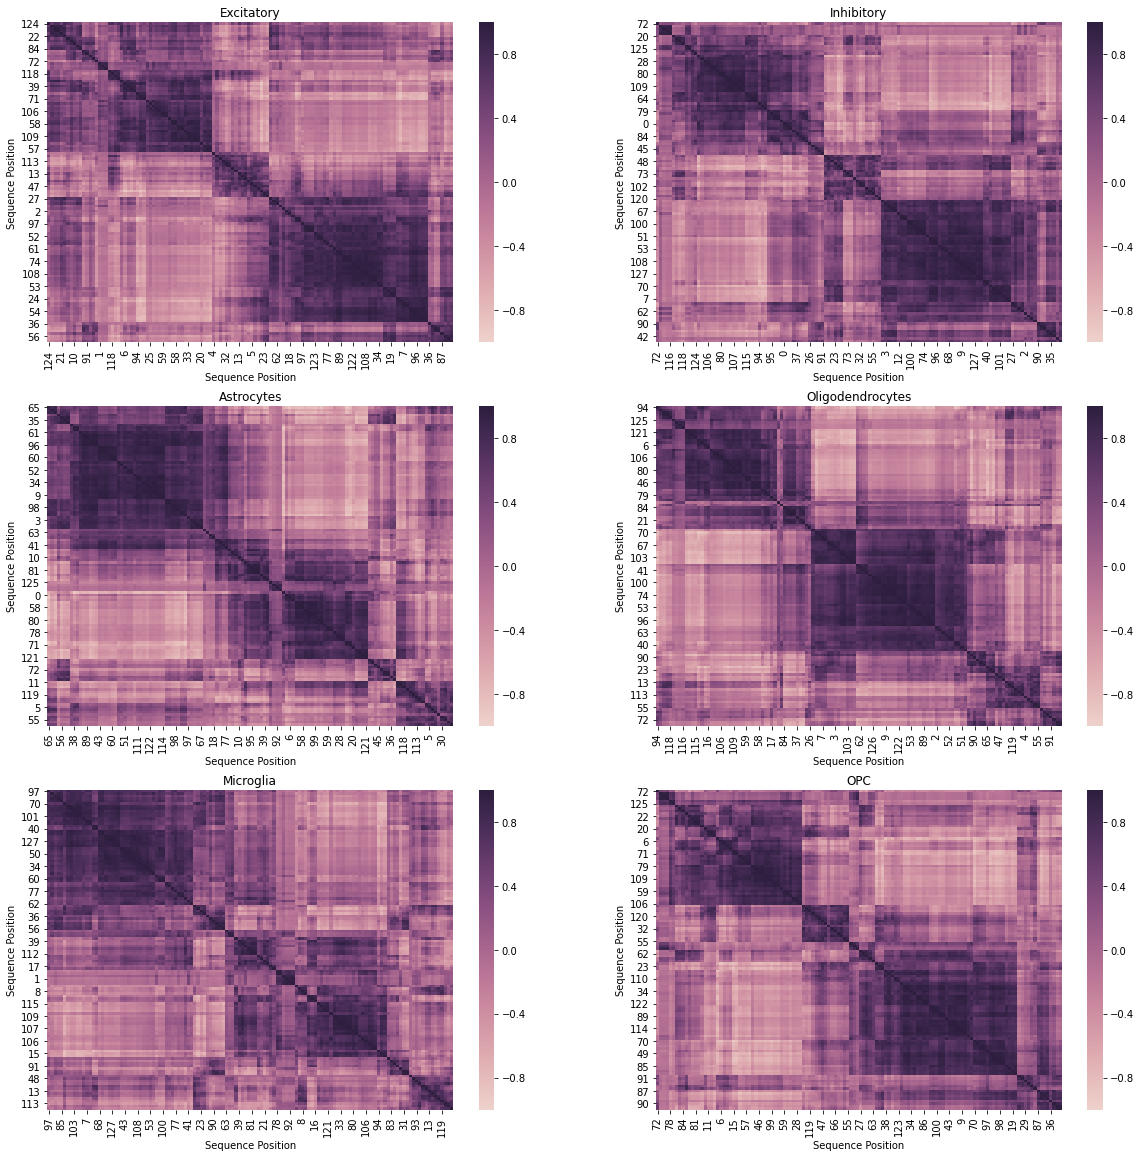

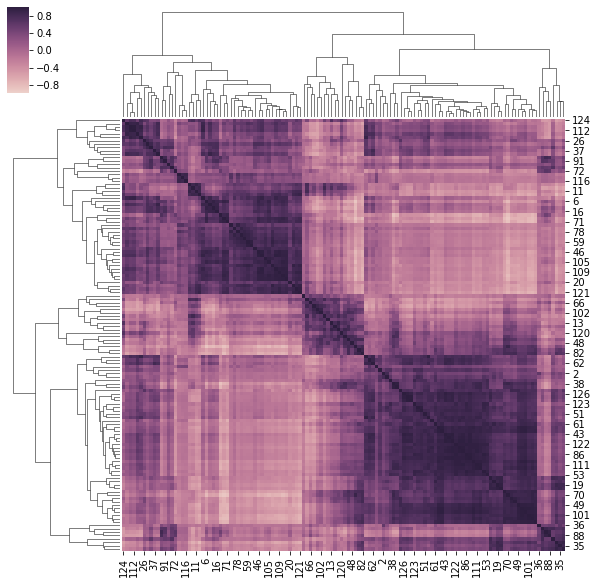

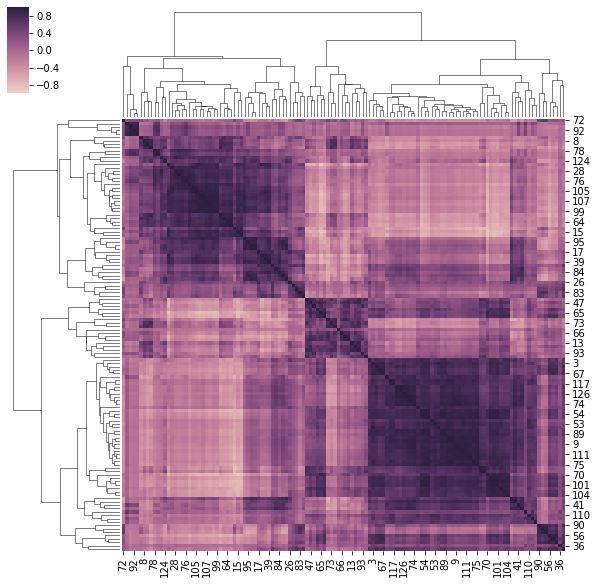

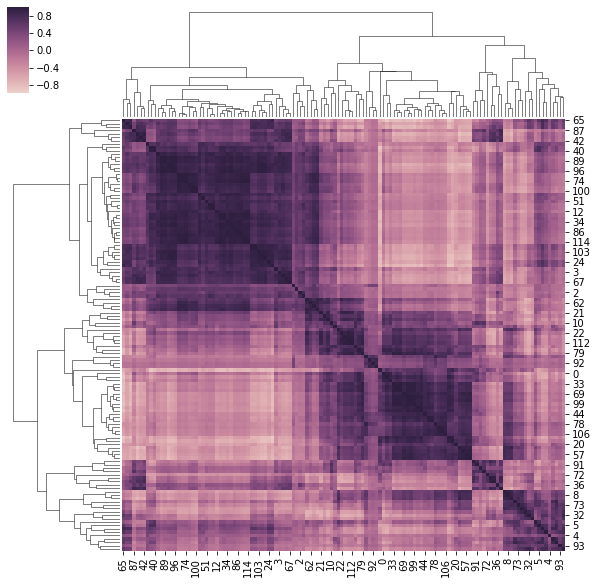

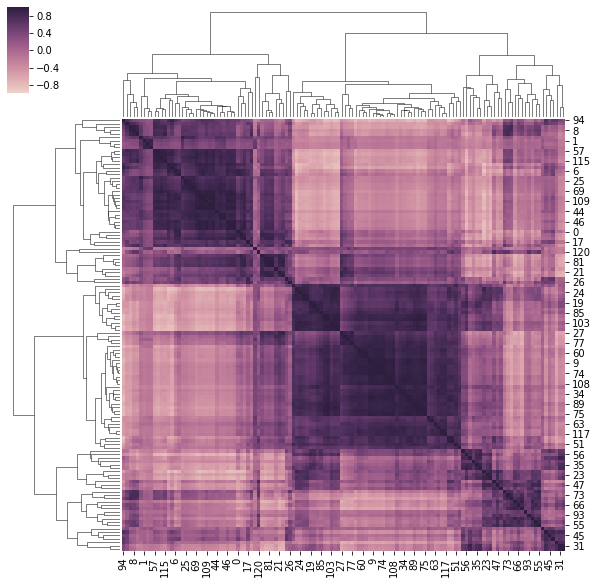

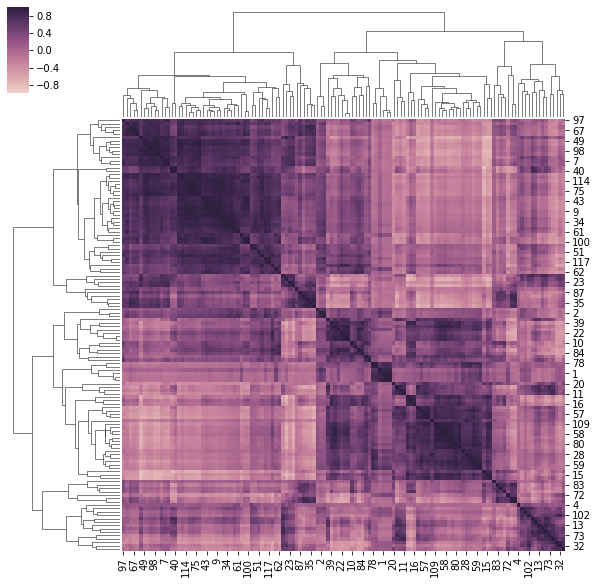

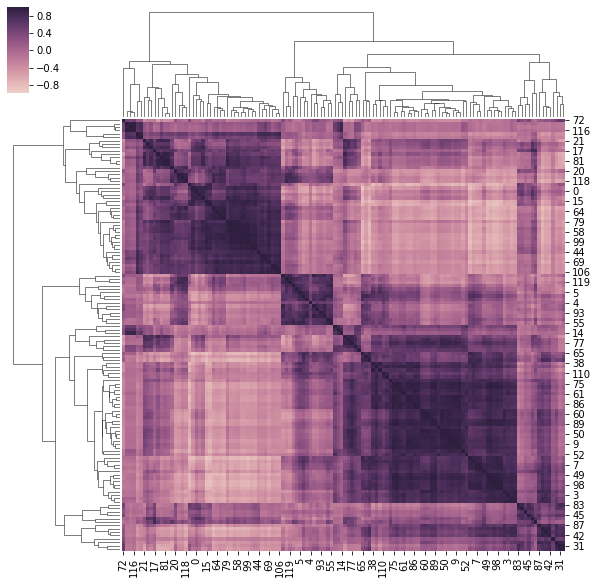

In [21]:
# make 4 by 4 plot of the filter importance for each cell type
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()
main_cts = ['Excitatory', 'Inhibitory', 'Astrocytes', 'Oligodendrocytes', 'Microglia', 'OPC']
for i, ct in enumerate(main_cts): 
    # run filter_importance = np.mean(np.abs(filter_importance), dim=0)  for the numpy array filter_importance
    filter_importance_t = filter_importance_ct[ct]
    filter_importance_t[filter_importance_t < 0] = 0
    filter_importance_t = np.mean(filter_importance_ct[ct], axis=0)  # shape: (128, 200)
    # Calculate the correlation between filters at each position
    correlation = np.corrcoef(filter_importance_t)  
    ss = sns.clustermap(correlation, cmap=cls, vmin=-1, vmax=1)
    sns.heatmap(ss.data2d, cmap=cls, vmin=-1, vmax=1, ax = axs[i])
    axs[i].set_title(ct)
    axs[i].set_xlabel('Sequence Position')
    axs[i].set_ylabel('Sequence Position')
plt.show()

/home/aiden/anaconda3/envs/for_DL/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


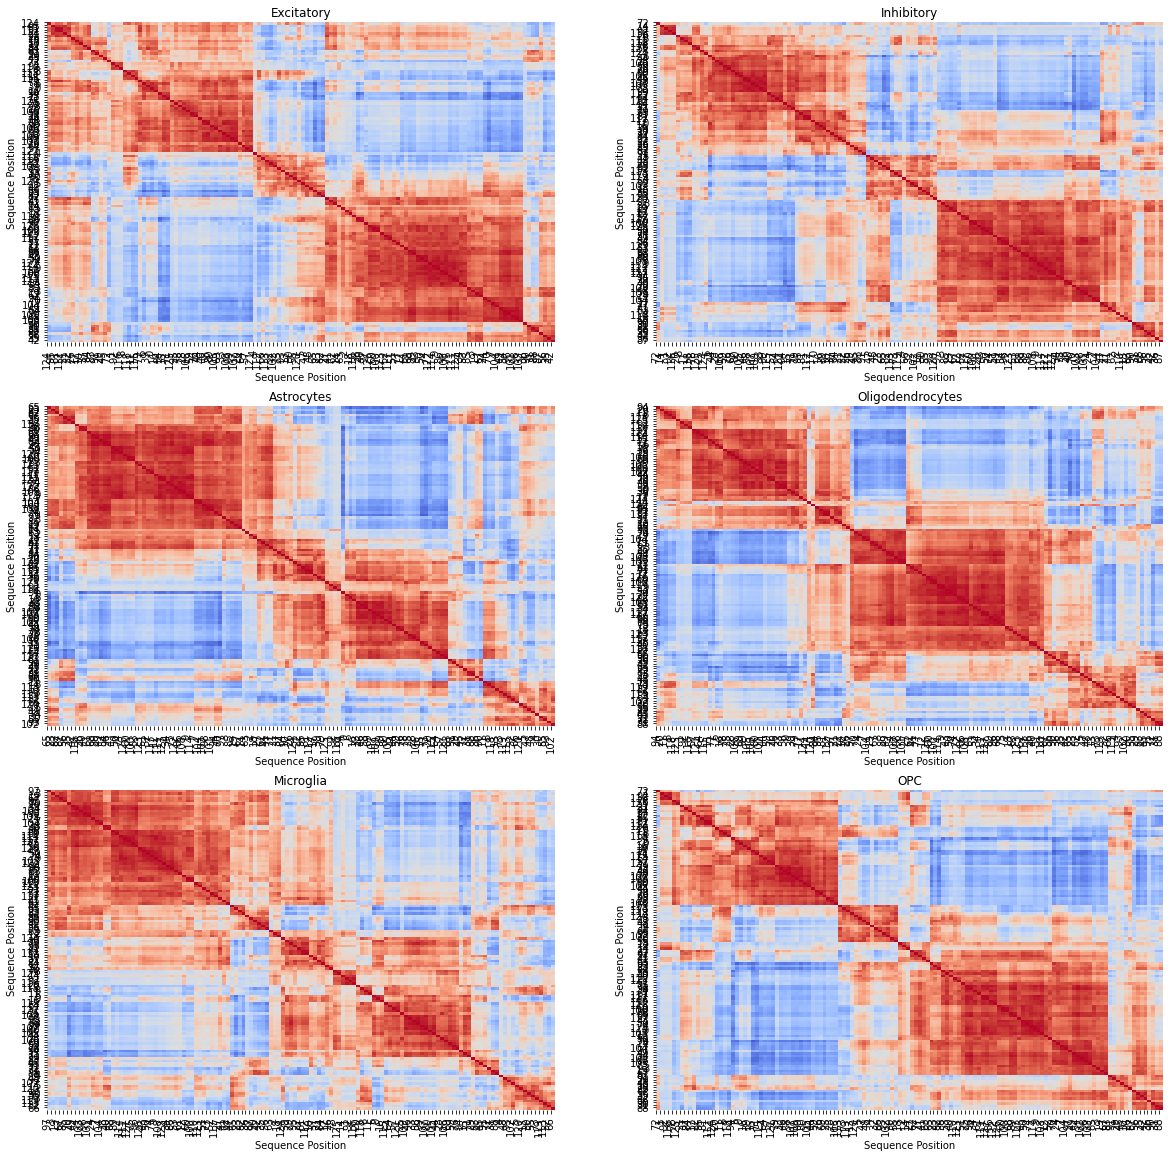

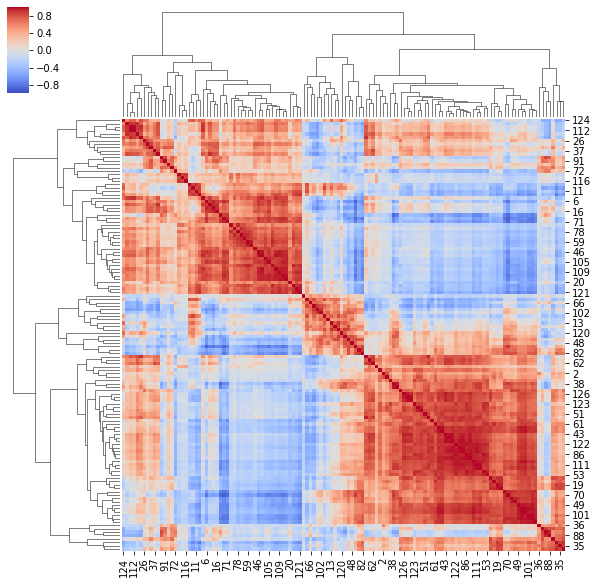

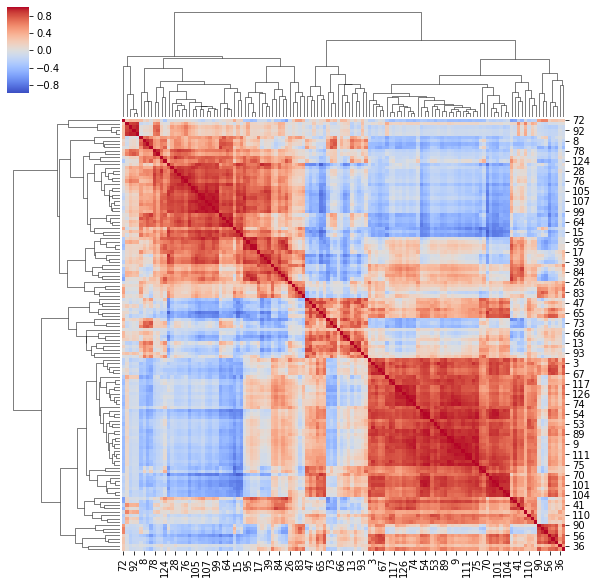

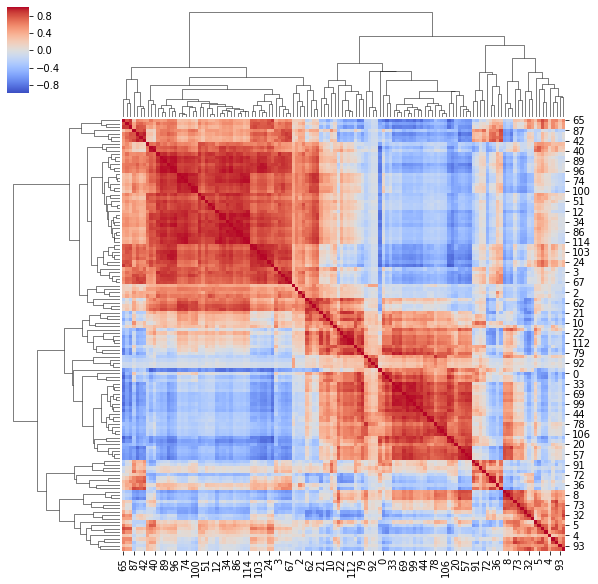

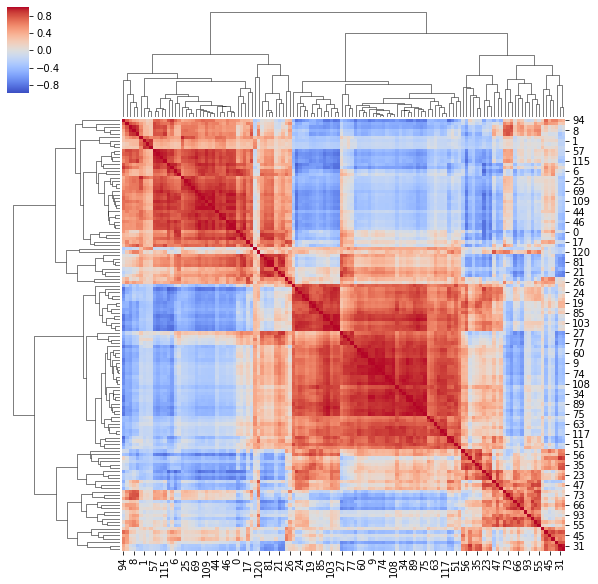

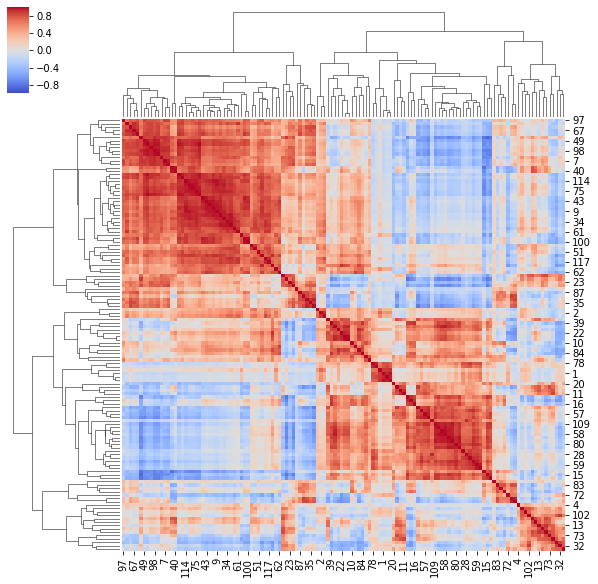

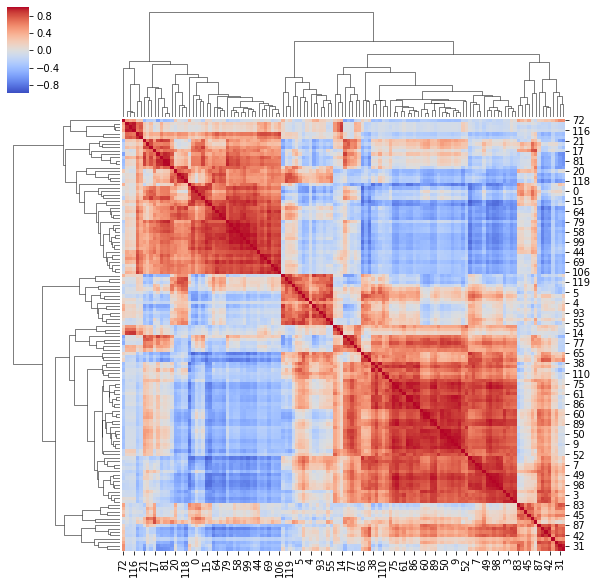

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ... (Your data preprocessing and filter_importance_ct calculation)

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()
main_cts = ['Excitatory', 'Inhibitory', 'Astrocytes', 'Oligodendrocytes', 'Microglia', 'OPC']
cls = 'coolwarm'  # Assuming you have defined 'cls' elsewhere

for i, ct in enumerate(main_cts):
    filter_importance_t = filter_importance_ct[ct]
    filter_importance_t[filter_importance_t < 0] = 0
    filter_importance_t = np.mean(filter_importance_ct[ct], axis=0)
    correlation = np.corrcoef(filter_importance_t)
    ss = sns.clustermap(correlation, cmap=cls, vmin=-1, vmax=1)

    sns.heatmap(ss.data2d, cmap=cls, vmin=-1, vmax=1, ax=axs[i], cbar=False)

    # Set x and y ticks and labels
    axs[i].set_xticks(np.arange(correlation.shape[0]))
    axs[i].set_yticks(np.arange(correlation.shape[1]))
    axs[i].set_xticklabels(ss.dendrogram_col.reordered_ind, rotation=90)
    axs[i].set_yticklabels(ss.dendrogram_row.reordered_ind, rotation=0)

    axs[i].set_title(ct)
    axs[i].set_xlabel('Sequence Position')
    axs[i].set_ylabel('Sequence Position')

plt.tight_layout()
plt.show()


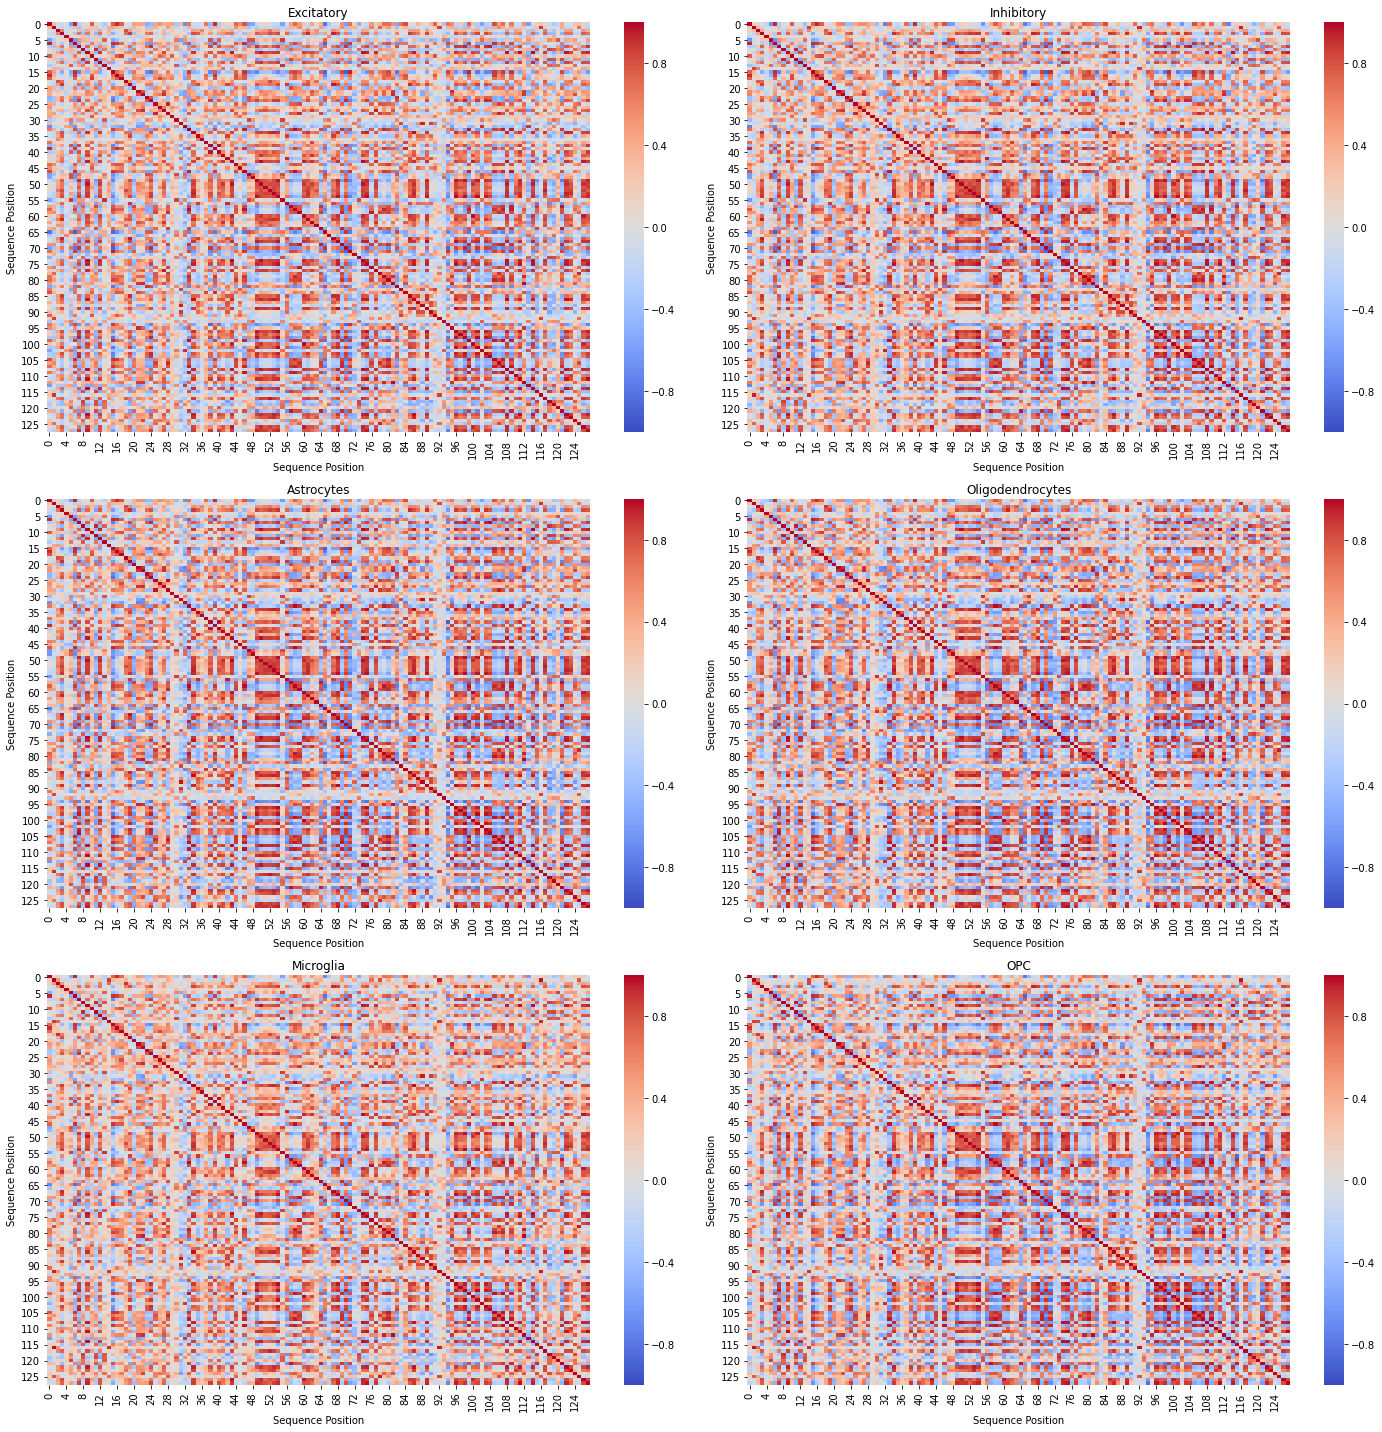

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ... (Your data preprocessing and filter_importance_ct calculation)

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
axs = axs.flatten()
main_cts = ['Excitatory', 'Inhibitory', 'Astrocytes', 'Oligodendrocytes', 'Microglia', 'OPC']
cls = 'coolwarm'  # Assuming you have defined 'cls' elsewhere

for i, ct in enumerate(main_cts):
    filter_importance_t = filter_importance_ct[ct]
    filter_importance_t[filter_importance_t < 0] = 0
    filter_importance_t = np.mean(filter_importance_ct[ct], axis=0)
    correlation = np.corrcoef(filter_importance_t)

    # Plot the heatmap without clustering
    sns.heatmap(correlation, cmap=cls, vmin=-1, vmax=1, ax=axs[i])

    axs[i].set_title(ct)
    axs[i].set_xlabel('Sequence Position')
    axs[i].set_ylabel('Sequence Position')

plt.tight_layout()
plt.show()


In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ... (Your data preprocessing and filter_importance_ct calculation)

main_cts = ['Excitatory', 'Inhibitory', 'Astrocytes', 'Oligodendrocytes', 'Microglia', 'OPC']
correlation_matrices = {}

for ct in main_cts:
    filter_importance_t = filter_importance_ct[ct]
    filter_importance_t[filter_importance_t < 0] = 0
    filter_importance_t = np.mean(filter_importance_ct[ct], axis=0)
    correlation = np.corrcoef(filter_importance_t)
    
    correlation_matrices[ct] = correlation

# Create an empty dissimilarity matrix
num_cts = len(main_cts)
dissimilarity_matrix = np.zeros((num_cts, num_cts))

# Compute the Frobenius norm for the difference between each pair of correlation matrices
for i, ct1 in enumerate(main_cts):
    for j, ct2 in enumerate(main_cts):
        if i < j:
            diff = correlation_matrices[ct1] - correlation_matrices[ct2]
            frobenius_norm = np.linalg.norm(diff, 'fro')
            dissimilarity_matrix[i, j] = frobenius_norm
            dissimilarity_matrix[j, i] = frobenius_norm  # The matrix is symmetric

# Customize the style and color palette
sns.set_style("white")
cmap = sns.color_palette("coolwarm_r")

# Display the dissimilarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dissimilarity_matrix, annot=True, fmt='.2f', cmap=cmap,
            xticklabels=main_cts, yticklabels=main_cts, cbar=False, ax=ax, linewidths=0.5, linecolor='black')

# Set plot title and labels
ax.set_title("Dissimilarity between Cell Types (Frobenius Norm)", fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

# Customize plot appearance
plt.tight_layout()
sns.despine()

# Save the plot to a high-resolution file
plt.savefig('dissimilarity_heatmap.png', dpi=300)

plt.show()


ValueError: Improper number of dimensions to norm.